In [90]:
import random            
import torch
import time
import torchvision
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import pandas as pd                                 
import numpy as np
import matplotlib.pyplot as plt  
from collections import defaultdict
from datetime import timedelta
from torch.utils.data import Dataset, DataLoader

In [133]:
class Bi_LSTM_AutoEncoder(nn.Module):
    def __init__(self,in_size, hidden_layers, encode=12, num_layers=3):
        super(Bi_LSTM_AutoEncoder, self).__init__()
        self.encoderlstm = nn.LSTM(in_size, hidden_layers, num_layers=num_layers, bidirectional=True)
        self.encoderlinear = nn.Linear(2*hidden_layers, encode)
        
        self.decoderlstm = nn.LSTM(encode, hidden_layers, num_layers=num_layers, bidirectional=True)
        self.decoderlinear = nn.Linear(2*hidden_layers, in_size)
    def forward(self, x):
        encoded, _ = self.encoderlstm(x)
        encoded = self.encoderlinear(encoded)
        decoded, _ = self.decoderlstm(encoded)
        decoded = self.decoderlinear(decoded)
        return decoded

In [134]:
class Loader(torch.utils.data.Dataset):
    def __init__(self):
        super(Loader, self).__init__()
        self.dataset = ''
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        row = row.drop(labels={'label'})
        data = torch.reshape(torch.from_numpy(np.array(row)/255).float(),(28,28))
        return data
    
class Train_Loader(Loader):
    def __init__(self):
        super(Train_Loader, self).__init__()
        self.dataset = pd.read_csv(
                       'mnist_train.csv',
                       index_col=False
                       )

In [135]:
batch_size = 32
lr = 1e-2         # learning rate
w_d = 1e-5        # weight decay
momentum = 0.9   
epochs = 15

train_set = Train_Loader()
train_ = torch.utils.data.DataLoader(
            train_set,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True
        )

In [136]:
metrics = defaultdict(list)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model= Bi_LSTM_AutoEncoder(28, 256)
model.to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=w_d)

In [138]:
model.train()
start = time.time()
print('starting training')
for epoch in range(epochs):
    ep_start = time.time()
    running_loss = 0.0
    for bx, data in enumerate(train_):
        data = data.to(device)
        #print(data.shape)
        sample = model(data)
        loss = criterion(data, sample)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss/len(train_set)
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.time()
    print('-----------------------------------------------')
    print('[EPOCH] {}/{}\n[LOSS] {}'.format(epoch+1,epochs,epoch_loss))
    print('Epoch Complete in {}'.format(timedelta(seconds=ep_end-ep_start)))
end = time.time()
print('-----------------------------------------------')
print('[System Complete: {}]'.format(timedelta(seconds=end-start)))

KeyboardInterrupt: 

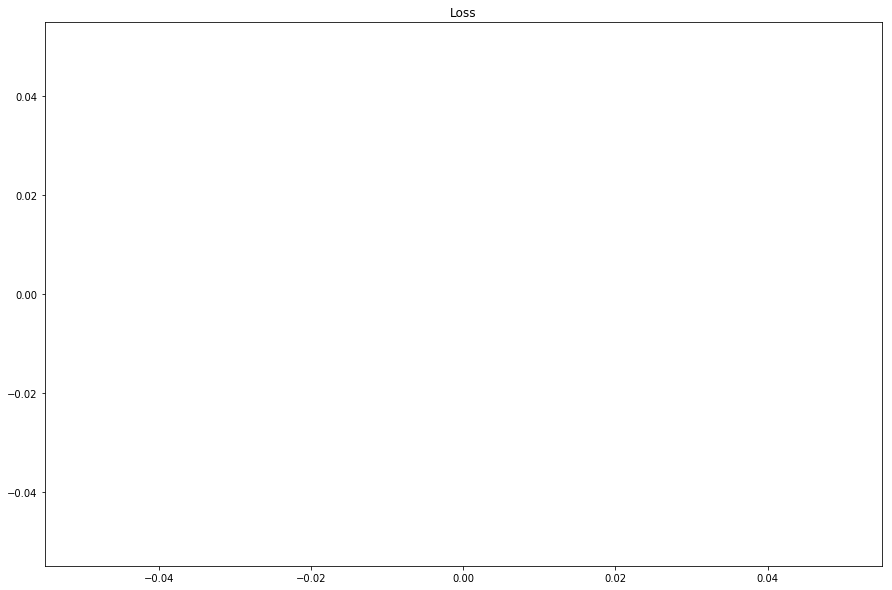

In [76]:
# train loss
_, ax = plt.subplots(1,1,figsize=(15,10))
ax.set_title('Loss')
ax.plot(metrics['train_loss'])

In [ ]:
# Get threshold
model.eval()
loss_dist = []
anom = pd.read_csv('data/abnormal.csv', index_col=[0])

for i in range(len(anom)):
    data = torch.from_numpy(np.array(anom.iloc[i][1:])/255).float()
    sample = model(data.to(device))
    loss = criterion(data.to(device), sample)
    loss_dist.append(loss.item())

loss_sc = []
for i in loss_dist:
    loss_sc.append((i,i))
plt.scatter(*zip(*loss_sc))
plt.axvline(0.3, 0.0, 1)

In [ ]:
# Plot threshold
lower_threshold = 0.0
upper_threshold = 0.3
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.distplot(loss_dist,bins=100,kde=True, color='blue')
plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='b')

In [ ]:
# Confusion matrix
df = pd.read_csv('data/anom.csv', index_col=[0])
ddf = pd.DataFrame(columns=df.columns)
tp = 0
fp = 0
tn = 0
fn = 0
total_anom = 0
for i in range(len(loss_dist)):
    total_anom += df.iloc[i]['label']
    if loss_dist[i] >= upper_threshold:
        n_df = pd.DataFrame([df.iloc[i]])
        n_df['loss'] = loss_dist[i]
        ddf = pd.concat([df,n_df], sort = True)
        if float(df.iloc[i]['label']) == 1.0:
            tp += 1
        else:
            fp += 1
    else:
        if float(df.iloc[i]['label']) == 1.0:
            fn += 1
        else:
            tn += 1
print('[TP] {}\t[FP] {}\t[MISSED] {}'.format(tp, fp, total_anom-tp))
print('[TN] {}\t[FN] {}'.format(tn, fn))

In [ ]:
conf = np.array([[tn,fp],[fn,tp]])
plt.figure()
sns.heatmap(conf,annot=True,annot_kws={"size": 16},fmt='g')